# ???

### About this notebook

This notebook was used for a project in the 50.039 Deep Learning course at the Singapore University of Technology and Design.

**Author:** Leong Keng Hoy (kenghoy_leong@sutd.edu.sg)

**Requirements:**
Fill up later
- Python 3 (tested on v3.10.0)
- Matplotlib (tested on v3.7.1)
- Numpy (tested on v1.24.3)

### Imports

In [2]:
import random
# Matplotlib
import matplotlib.pyplot as plt
# Numpy
import numpy as np
# Pandas
import pandas as pd
# Torch
import torch
from torch.utils.data import Dataset, random_split, DataLoader
from torchmetrics.classification import BinaryAccuracy

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Use GPU if available, else use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


### Load Dataset

In [52]:
class DiabetesDataset(Dataset):
    def __init__(self, data):
        self.data = data
        self.dataset_length = len(self.data) # 768

        self.input_features_no = 8
        self.input_features = self.data.iloc[:, :self.input_features_no]
        self.input_features = (self.input_features - self.input_features.mean()) / self.input_features.std()

        self.output_features_no = 1
        self.output_features = self.data.iloc[:, self.input_features_no]

        generator = torch.Generator().manual_seed(42)
        self.train_set, self.val_set, self.test_set = random_split(self, [0.8, 0.1, 0.1], generator) 

    def __getitem__(self, index):
        # Fetch inputs
        x = self.input_features.iloc[index].values
        # Fetch outputs
        y = self.output_features.iloc[index]
        return x, y

    def __len__(self):
        return len(self.data)

In [56]:
df = pd.read_csv("./diabetes.csv")
print(len(df))
train, val, test = np.split(df.sample(frac=1, random_state=42), [int(.8*len(df)), int(.9*len(df))])

train_set = DiabetesDataset(train)
# print(len(train_set))
# print(train_set[0])

val_set = DiabetesDataset(val)
# print(len(val_set))
# print(val_set[0])

test_set = DiabetesDataset(test)
# print(len(test_set))
# print(test_set[0])

train_batch_size = 128
test_batch_size = 64
train_dataloader = DataLoader(train_set, batch_size = train_batch_size, shuffle = True)
val_dataloader = DataLoader(val_set, batch_size = test_batch_size, shuffle = False)
test_dataloader = DataLoader(test_set, batch_size = test_batch_size, shuffle = False)

768


### Setting Up Models

In [5]:
class TwoLayerNN(torch.nn.Module):
    def __init__(self, n_x, n_h, n_y, activation):
        super().__init__()
        self.fc1 = torch.nn.Linear(n_x, n_h)
        self.fc2 = torch.nn.Linear(n_h, n_y)
        self.activation = activation

        self.accuracy = BinaryAccuracy()

    def forward(self, x):
        out1 = self.fc1(x)
        act1 = self.activation(out1)
        out2 = self.fc2(act1)
        act2 = torch.sigmoid(out2)
        return act2

In [6]:
class FiveLayerNN(torch.nn.Module):
    def __init__(self, n_x, n_h, n_y, activation):
        super().__init__()
        self.fc1 = torch.nn.Linear(n_x, n_h[0])
        self.fc2 = torch.nn.Linear(n_h[0], n_h[1])
        self.fc3 = torch.nn.Linear(n_h[1], n_h[2])
        self.fc4 = torch.nn.Linear(n_h[2], n_h[3])
        self.fc5 = torch.nn.Linear(n_h[3], n_y)
        self.activation = activation

        self.accuracy = BinaryAccuracy()

    def forward(self, x):
        out1 = self.fc1(x)
        act1 = self.activation(out1)
        out2 = self.fc2(act1)
        act2 = self.activation(out2)
        out3 = self.fc3(act2)
        act3 = self.activation(out3)
        out4 = self.fc4(act3)
        act4 = self.activation(out4)
        out5 = self.fc5(act4)
        act5 = torch.sigmoid(out5)
        return act5

### Setting Up Trainer

In [25]:
def search_trainer(model, train_loader, test_loader, epochs, optim, lr):
    
    # History for train acc, test acc
    train_accs = []
    test_accs = []
    
    # Define optimizer
    optimizer = optim(model.parameters(), lr = lr)

    # Training model
    num_epochs = epochs
    for epoch in range(num_epochs):

        # Go through all samples in train dataset
        model.train()
        for i, (inputs, labels) in enumerate(train_loader):
            # Get from dataloader and send to device
            inputs = inputs.to(device, torch.float32)
            labels = labels.to(device, torch.float32)

            # Forward pass
            outputs = model(inputs)
            outputs = outputs.view(outputs.size(0))

            # Compute loss
            # print(outputs.size())
            # print(labels.size())
            loss = torch.nn.functional.binary_cross_entropy(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Display
            # if (i+1) % 10 == 0:
            #     print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Train Loss: {loss.item():.4f}')

        # Compute model train accuracy on test after all samples have been seen using test samples
        model.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            for inputs, labels in train_loader:
                # Get inputs and labels from test loader
                inputs = inputs.to(device, torch.float32)
                labels = labels.to(device, torch.float32)

                # Forward pass and predict class using max
                outputs = model(inputs)
                outputs = outputs.view(outputs.size(0))

                predicted = torch.round(outputs.data)

                # Check if predicted class matches label and count numbler of correct predictions
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for inputs, labels in test_loader:
            # Get inputs and labels from test loader
            inputs = inputs.to(device, torch.float32)
            labels = labels.to(device, torch.float32)

            # Forward pass and predict class using max
            outputs = model(inputs)
            outputs = outputs.view(outputs.size(0))

            predicted = torch.round(outputs.data)

            # Check if predicted class matches label and count numbler of correct predictions
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        # Compute final accuracy and display
        test_accuracy = correct/total
    # Return
    return test_accuracy

In [26]:
def trainer(model, train_loader, val_loader, test_loader, epochs, optim, lr):
    
    # History for train acc, validation acc
    train_accs = []
    val_accs = []
    
    # Define optimizer
    optimizer = optim(model.parameters(), lr = lr)

    # Training model
    num_epochs = epochs
    for epoch in range(num_epochs):

        # Go through all samples in train dataset
        model.train()
        for i, (inputs, labels) in enumerate(train_loader):
            # Get from dataloader and send to device
            inputs = inputs.to(device, torch.float32)
            labels = labels.to(device, torch.float32)

            # Forward pass
            outputs = model(inputs)
            outputs = outputs.view(outputs.size(0))

            # Compute loss
            # print(outputs.size())
            # print(labels.size())
            loss = torch.nn.functional.binary_cross_entropy(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Display
            # if (i+1) % 10 == 0:
            #     print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Train Loss: {loss.item():.4f}')

        # Compute model train accuracy on test after all samples have been seen using test samples
        model.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            for inputs, labels in train_loader:
                # Get inputs and labels from test loader
                inputs = inputs.to(device, torch.float32)
                labels = labels.to(device, torch.float32)

                # Forward pass and predict class using max
                outputs = model(inputs)
                outputs = outputs.view(outputs.size(0))

                predicted = torch.round(outputs.data)

                # Check if predicted class matches label and count numbler of correct predictions
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        # Compute final accuracy and display
        train_accuracy = correct/total
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Accuracy: {train_accuracy:.4f}')
        train_accs.append(train_accuracy)
        
        # Compute model validation accuracy on test after all samples have been seen using test samples
        model.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            for inputs, labels in val_loader:
                # Get inputs and labels from val loader
                inputs = inputs.to(device, torch.float32)
                labels = labels.to(device, torch.float32)

                # Forward pass and predict class using max
                outputs = model(inputs)
                outputs = outputs.view(outputs.size(0))

                predicted = torch.round(outputs.data)

                # Check if predicted class matches label and count numbler of correct predictions
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        # Compute final accuracy and display
        val_accuracy = correct/total
        print(f'Epoch [{epoch+1}/{num_epochs}], Validation Accuracy: {val_accuracy:.4f}')
        val_accs.append(val_accuracy)

    # Compute model test accuracy on test after all samples have been seen using test samples
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for inputs, labels in test_loader:
            # Get inputs and labels from test loader
            inputs = inputs.to(device, torch.float32)
            labels = labels.to(device, torch.float32)

            # Forward pass and predict class using max
            outputs = model(inputs)
            outputs = outputs.view(outputs.size(0))

            predicted = torch.round(outputs.data)

            # Check if predicted class matches label and count numbler of correct predictions
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    # Compute final accuracy and display
    test_accuracy = correct/total
    print(f'Test Accuracy: {test_accuracy:.4f}')

    # Return
    return train_accs, val_accs

### Performing Hyperparameter Search

In [42]:
def TwoLayerGridSearch():
    n_h = [16,32,64,128]
    activation = [torch.relu, torch.celu]
    optim = [torch.optim.Adam, torch.optim.Adadelta, torch.optim.RMSprop, torch.optim.RAdam, torch.optim.Adagrad]
    lr = [5e-3, 1e-2, 2e-2]

    best_acc = 0
    
    for n in n_h:
        for a in activation:
            for o in optim:
                for l in lr:
                    torch.manual_seed(42)
                    model = TwoLayerNN(n_x = 8, n_h = n, n_y = 1, activation= a).to(device)
                    test_acc = search_trainer(model, train_dataloader, test_dataloader, epochs=200, optim=o, lr=l)
                    print(f"n_h={n}, activation={a.__name__}, optimizer={o.__name__}, lr={l}: Test Accuracy = {test_acc}")
                    if test_acc > best_acc:
                        best_acc = test_acc
                        best_model = [n,a,o,l]

    return f"Best: Test Acc = {best_acc:.4f}, n_h={best_model[0]}, activation={best_model[1].__name__}, optimizer={best_model[2].__name__}, lr={best_model[3]}"

In [58]:
# New attempt (after normalization)
TwoLayerGridSearch()

n_h=16, activation=relu, optimizer=Adam, lr=0.005: Test Accuracy = 0.7532467532467533
n_h=16, activation=relu, optimizer=Adam, lr=0.01: Test Accuracy = 0.7792207792207793
n_h=16, activation=relu, optimizer=Adam, lr=0.02: Test Accuracy = 0.7402597402597403
n_h=16, activation=relu, optimizer=Adadelta, lr=0.005: Test Accuracy = 0.33766233766233766
n_h=16, activation=relu, optimizer=Adadelta, lr=0.01: Test Accuracy = 0.45454545454545453
n_h=16, activation=relu, optimizer=Adadelta, lr=0.02: Test Accuracy = 0.7272727272727273
n_h=16, activation=relu, optimizer=RMSprop, lr=0.005: Test Accuracy = 0.7662337662337663
n_h=16, activation=relu, optimizer=RMSprop, lr=0.01: Test Accuracy = 0.7272727272727273
n_h=16, activation=relu, optimizer=RMSprop, lr=0.02: Test Accuracy = 0.7662337662337663
n_h=16, activation=relu, optimizer=RAdam, lr=0.005: Test Accuracy = 0.7922077922077922
n_h=16, activation=relu, optimizer=RAdam, lr=0.01: Test Accuracy = 0.8051948051948052
n_h=16, activation=relu, optimizer=R

'Best: Test Acc = 0.8182, n_h=16, activation=relu, optimizer=Adagrad, lr=0.005'

In [62]:
def FiveLayerGridSearch():
    n_h = [[256,128,64,32], [160,80,40,20], [128,64,32,16]]
    activation = [torch.relu, torch.celu]
    optim = [torch.optim.Adam, torch.optim.RAdam, torch.optim.Adagrad, torch.optim.Adadelta]
    lr = [5e-3, 1e-2, 2e-2]

    best_acc = 0
    
    for n in n_h:
        for a in activation:
            for o in optim:
                for l in lr:
                    torch.manual_seed(42)
                    model = FiveLayerNN(n_x = 8, n_h = n, n_y = 1, activation= a).to(device)
                    test_acc = search_trainer(model, train_dataloader, test_dataloader, epochs=100, optim=o, lr=l)
                    print(f"n_h = {n}, activation = {a.__name__}, optimizer = {o.__name__}, lr = {l}: Test Accuracy = {test_acc:.4f}")
                    if test_acc > best_acc:
                        best_acc = test_acc
                        best_model = [n,a,o,l]

    return f"Best: Test Acc = {best_acc:.4f}, n_h = {best_model[0]}, activation = {best_model[1].__name__}, optimizer = {best_model[2].__name__}, lr={best_model[3]}"

In [63]:
FiveLayerGridSearch()

n_h = [256, 128, 64, 32], activation = relu, optimizer = Adam, lr = 0.005: Test Accuracy = 0.7273
n_h = [256, 128, 64, 32], activation = relu, optimizer = Adam, lr = 0.01: Test Accuracy = 0.6883
n_h = [256, 128, 64, 32], activation = relu, optimizer = Adam, lr = 0.02: Test Accuracy = 0.7273
n_h = [256, 128, 64, 32], activation = relu, optimizer = RAdam, lr = 0.005: Test Accuracy = 0.7143
n_h = [256, 128, 64, 32], activation = relu, optimizer = RAdam, lr = 0.01: Test Accuracy = 0.6883
n_h = [256, 128, 64, 32], activation = relu, optimizer = RAdam, lr = 0.02: Test Accuracy = 0.7662
n_h = [256, 128, 64, 32], activation = relu, optimizer = Adagrad, lr = 0.005: Test Accuracy = 0.7403
n_h = [256, 128, 64, 32], activation = relu, optimizer = Adagrad, lr = 0.01: Test Accuracy = 0.7662
n_h = [256, 128, 64, 32], activation = relu, optimizer = Adagrad, lr = 0.02: Test Accuracy = 0.7532
n_h = [256, 128, 64, 32], activation = relu, optimizer = Adadelta, lr = 0.005: Test Accuracy = 0.6494
n_h = [256

'Best: Test Acc = 0.8052, n_h = [256, 128, 64, 32], activation = celu, optimizer = Adadelta, lr=0.02'

In [27]:
def show_training_curves(train_accs, val_accs):
        # Initialize matplotlib
        fig, axs = plt.subplots(1, 2, figsize = (15, 7))
        axs[0].plot(list(range(len(train_accs))), train_accs)
        axs[0].set_xlabel("Iteration number")
        axs[0].set_ylabel("Training accuracy")
        axs[1].plot(list(range(len(val_accs))), val_accs)
        axs[1].set_xlabel("Iteration number")
        axs[1].set_ylabel("Validation accuracy")
        # Display
        plt.show()

Epoch [1/2000], Train Accuracy: 0.3388
Epoch [1/2000], Validation Accuracy: 0.4026
Epoch [2/2000], Train Accuracy: 0.3469
Epoch [2/2000], Validation Accuracy: 0.4156
Epoch [3/2000], Train Accuracy: 0.3583
Epoch [3/2000], Validation Accuracy: 0.4026
Epoch [4/2000], Train Accuracy: 0.3795
Epoch [4/2000], Validation Accuracy: 0.4026
Epoch [5/2000], Train Accuracy: 0.4055
Epoch [5/2000], Validation Accuracy: 0.4286
Epoch [6/2000], Train Accuracy: 0.4723
Epoch [6/2000], Validation Accuracy: 0.4545
Epoch [7/2000], Train Accuracy: 0.5244
Epoch [7/2000], Validation Accuracy: 0.4545
Epoch [8/2000], Train Accuracy: 0.5668
Epoch [8/2000], Validation Accuracy: 0.4805
Epoch [9/2000], Train Accuracy: 0.5977
Epoch [9/2000], Validation Accuracy: 0.5065
Epoch [10/2000], Train Accuracy: 0.6221
Epoch [10/2000], Validation Accuracy: 0.5714
Epoch [11/2000], Train Accuracy: 0.6384
Epoch [11/2000], Validation Accuracy: 0.6234
Epoch [12/2000], Train Accuracy: 0.6629
Epoch [12/2000], Validation Accuracy: 0.623

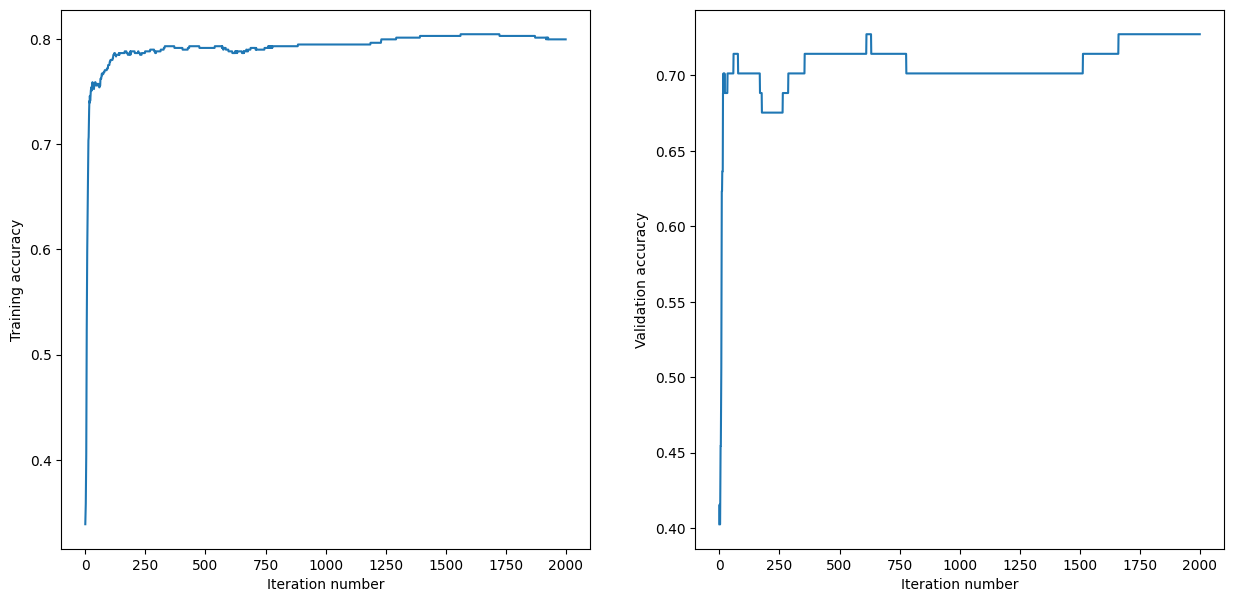

In [60]:
torch.manual_seed(42)
#  Full training of the 2-layer model
model1 = TwoLayerNN(n_x = 8, n_h = 16, n_y = 1, activation = torch.relu).to(device)
train_accs1, val_accs1 = trainer(model1, train_dataloader, val_dataloader, test_dataloader, epochs=2000, optim=torch.optim.Adagrad, lr=5e-3)
# print(f"Test Accuracy: {test_acc1:.4f}")
show_training_curves(train_accs1, val_accs1)

Epoch [1/1000], Train Accuracy: 0.6010
Epoch [1/1000], Validation Accuracy: 0.6364
Epoch [2/1000], Train Accuracy: 0.6270
Epoch [2/1000], Validation Accuracy: 0.6494
Epoch [3/1000], Train Accuracy: 0.6661
Epoch [3/1000], Validation Accuracy: 0.6234
Epoch [4/1000], Train Accuracy: 0.6906
Epoch [4/1000], Validation Accuracy: 0.6364
Epoch [5/1000], Train Accuracy: 0.6938
Epoch [5/1000], Validation Accuracy: 0.6883
Epoch [6/1000], Train Accuracy: 0.6987
Epoch [6/1000], Validation Accuracy: 0.7013
Epoch [7/1000], Train Accuracy: 0.7052
Epoch [7/1000], Validation Accuracy: 0.7013
Epoch [8/1000], Train Accuracy: 0.7134
Epoch [8/1000], Validation Accuracy: 0.7013
Epoch [9/1000], Train Accuracy: 0.7117
Epoch [9/1000], Validation Accuracy: 0.7013
Epoch [10/1000], Train Accuracy: 0.7150
Epoch [10/1000], Validation Accuracy: 0.7013
Epoch [11/1000], Train Accuracy: 0.7215
Epoch [11/1000], Validation Accuracy: 0.7013
Epoch [12/1000], Train Accuracy: 0.7264
Epoch [12/1000], Validation Accuracy: 0.701

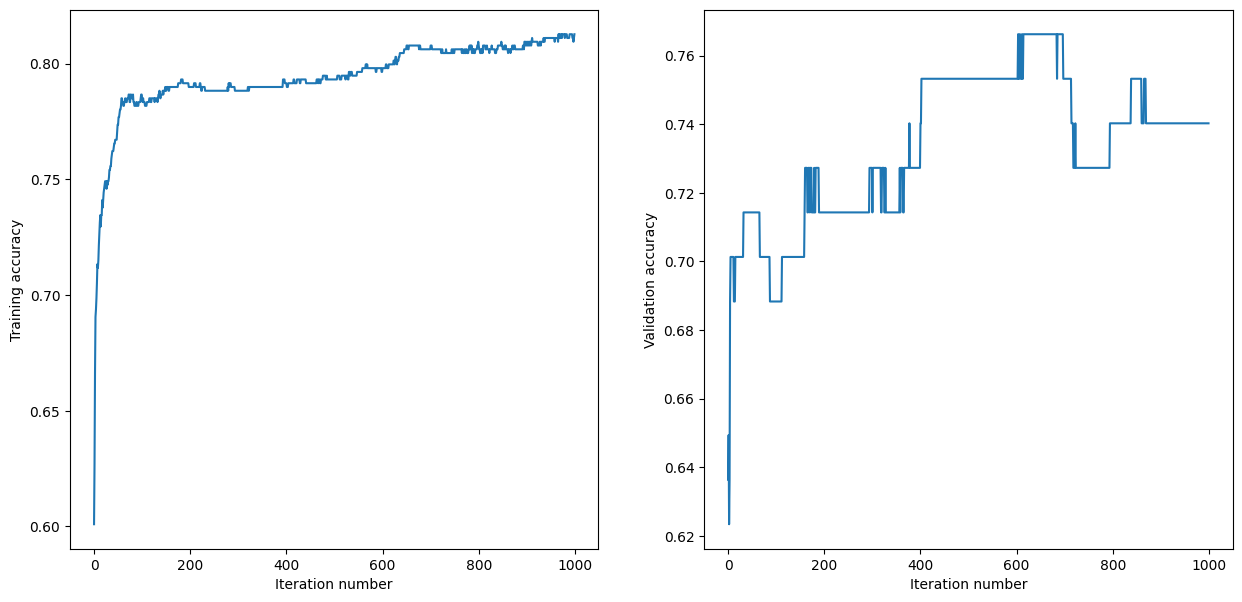

In [64]:
torch.manual_seed(42)
#  Full training of the 5-layer model
model2 = FiveLayerNN(n_x = 8, n_h = [256,128,64,32], n_y = 1, activation = torch.celu).to(device)
train_accs2, val_accs2 = trainer(model2, train_dataloader, val_dataloader, test_dataloader, epochs=1000, optim=torch.optim.Adadelta, lr=2e-2)
# print(f"Test Accuracy: {test_acc2:.4f}")
show_training_curves(train_accs2, val_accs2)